# Marginal Uniformization

In this notebook, we are going to demonstrate how we do uniformization. Uniformization is when we turn any univariate distribution into a uniform distribution. This works by taking finding the CDF of a function

This is mainly used for inverse sampling but in theory, we can go from a uniform distribution to any other distribution but taking

In [8]:
import os, sys
from pyprojroot import here
# sys.path.insert(0, f"{cwd}/../")
sys.path.append(str(here()))

from rbig.data import ToyData
from rbig.transform.uniformization import HistogramUniformization, KDEUniformization
from rbig.transform import MarginalUniformization

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [5]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

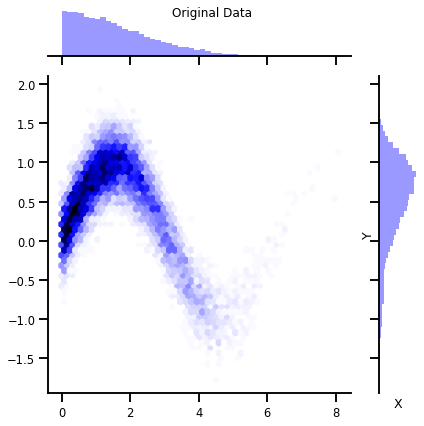

In [6]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
n_features = 2
noise = 0.25
random_state=1
clusters = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state,
    clusters=clusters,
).generate_samples()

X = data[:, 0]
Y = data[:, 1]

plot_2d_joint(data, title='Original Data')

So for this example, we are using a Beta distribution with an $\alpha$ value of 4 to generate a slightly skewed distribution.

## Method I - Histograms

For this first model, we will be using a simple histogram method. This works by binning the data 

### Fit Model to Distribution

In [95]:
# initialize HistogramClass
bins = 50 #int(np.sqrt(n_samples))
support_extension = 10
alpha = 1e-7
hist_clf = HistogramUniformization(
    bins=bins,
    support_extension=support_extension,
    alpha=alpha,
#     n_quantiles=100,
)

marg_hist_clf = MarginalUniformization(hist_clf)

# fit to data
marg_hist_clf.fit(data)

MarginalUniformization(transformer=HistogramUniformization(alpha=1e-07, bins=50,
                                                           kwargs={},
                                                           n_quantiles=None,
                                                           prob_tol=1e-07,
                                                           random_state=123,
                                                           subsample=10000,
                                                           support_extension=10))

### Transform Data

<Figure size 360x360 with 0 Axes>

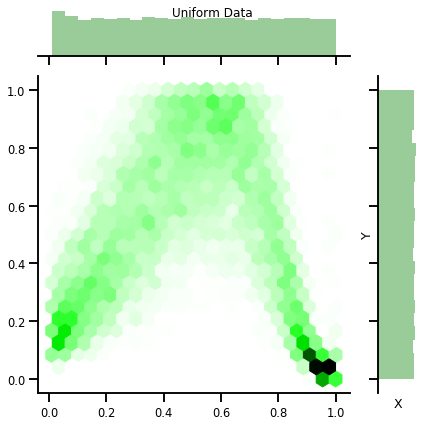

In [96]:
# transform data
Xu = marg_hist_clf.transform(data)

plot_2d_joint(Xu, title='Uniform Data', color='green')

### Inverse Transform Data

<Figure size 360x360 with 0 Axes>

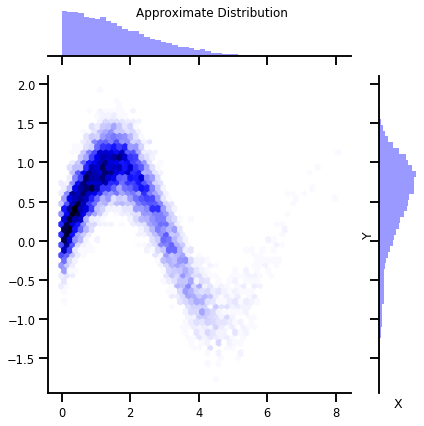

In [97]:
# transform data
X_approx = marg_hist_clf.inverse_transform(Xu)

plot_2d_joint(X_approx, title='Approximate Distribution', color='blue')

### Sampling

<Figure size 360x360 with 0 Axes>

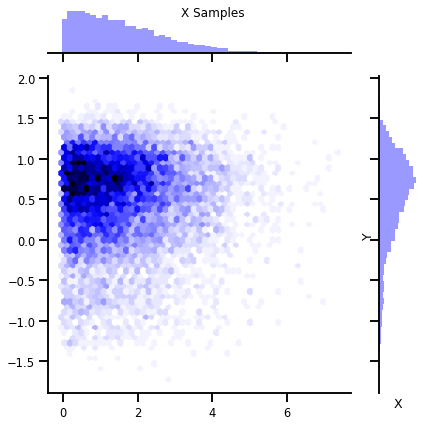

In [98]:
# transform data
X_samples = marg_hist_clf.sample(10_000, seed)

plot_2d_joint(X_samples, title='X Samples', color='blue')

### Jacobian (Log Absolute Determinant)

-6.873524613612788 -0.11815683593141853


<Figure size 360x360 with 0 Axes>

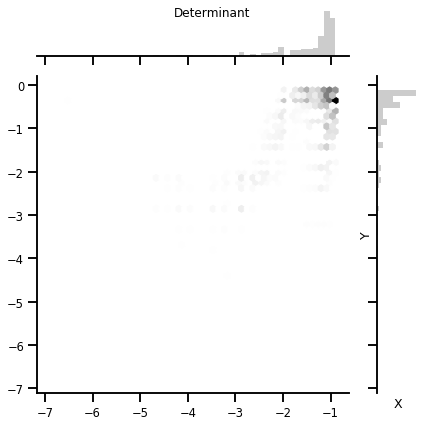

In [99]:
# estimated log probability of dataset
x_slogdet = marg_hist_clf.log_abs_det_jacobian(data)

print(x_slogdet.min(), x_slogdet.max())
plot_2d_joint(x_slogdet, title='Determinant', color='gray')

### Log Probability

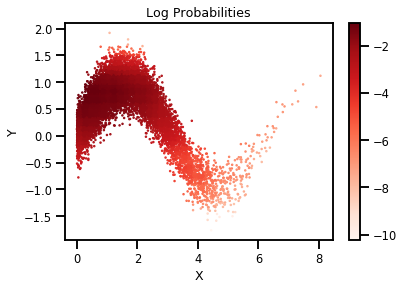

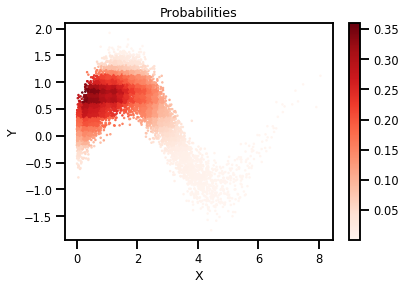

In [100]:
# calculate real log probability of distribution
x_prob = marg_hist_clf.score_samples(data)

plot_prob(data, x_prob, title='Log Probabilities')
plot_prob(data, np.exp(x_prob), title='Probabilities')

### Negative Log-Likelihood

In [101]:
x_score = marg_hist_clf.score(data)
print(x_score)

-2.1592380272701246


## Method II - KDE Method (Exact)

In [87]:
# initialize HistogramClass
bw_method = 'scott'
n_quantiles = 50
support_extension = 10
method = 'exact'
interp = True
kde_clf = KDEUniformization(
    bw_method=bw_method,
    n_quantiles=n_quantiles,
    support_extension=support_extension,
    method=method,
    interp=interp
)

# initialize HistogramClass
bw_method = 'scott'
n_quantiles = 100
support_extension = 10
method = 'fft'
interp = True
kde_clf = KDEUniformization(
    bw_method=bw_method,
    n_quantiles=n_quantiles,
    support_extension=support_extension,
    method=method,
    interp=interp
)

bw_method = 'scott'
n_quantiles = 1000
support_extension = 10
method = 'epa'
kernel = 'epa'
kde_clf = KDEUniformization(
    bw_method=bw_method,
    n_quantiles=n_quantiles,
    support_extension=support_extension,
    method=method,
    kernel=kernel,
)


marg_kde_clf = MarginalUniformization(kde_clf)

# fit to data
marg_kde_clf.fit(data)

MarginalUniformization(transformer=KDEUniformization(algorithm='kd_tree',
                                                     bw_method='scott',
                                                     interp=True, kernel='epa',
                                                     kwargs={}, method='epa',
                                                     metric='euclidean',
                                                     n_quantiles=1000, norm=2,
                                                     support_extension=10))

### Transform Data

<Figure size 360x360 with 0 Axes>

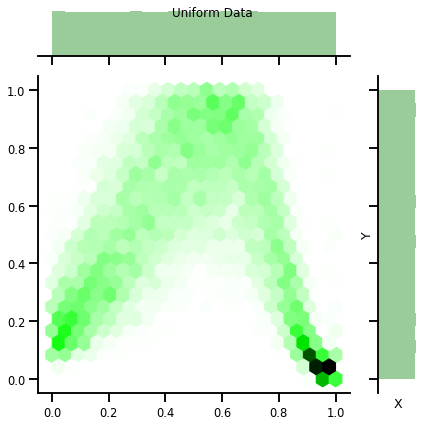

In [88]:
# transform data
Xu = marg_kde_clf.transform(data)

plot_2d_joint(Xu, title='Uniform Data', color='green')

### Inverse Transformation

<Figure size 360x360 with 0 Axes>

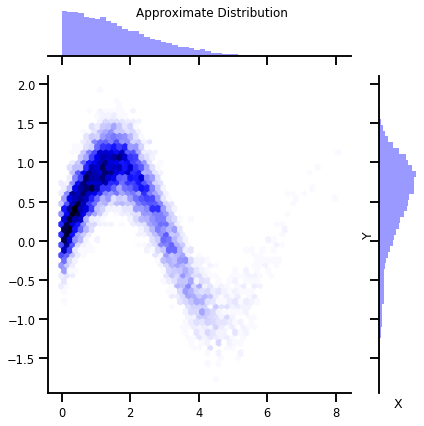

In [89]:
# transform data
X_approx = marg_kde_clf.inverse_transform(Xu)

plot_2d_joint(X_approx, title='Approximate Distribution', color='blue')

### Sampling

<Figure size 360x360 with 0 Axes>

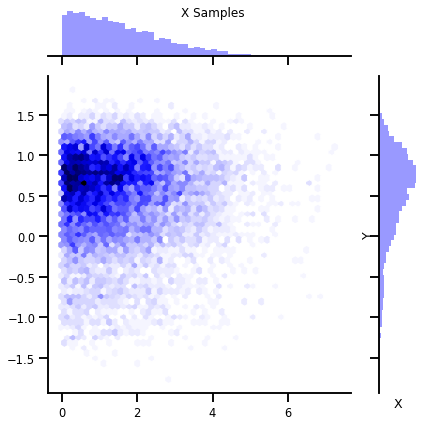

In [90]:
# transform data
X_samples = marg_kde_clf.sample(10_000, seed)

plot_2d_joint(X_samples, title='X Samples', color='blue')

### Jacobian (Log Absolute Determinant)

-8.010621631295786 -0.15507371489128807


<Figure size 360x360 with 0 Axes>

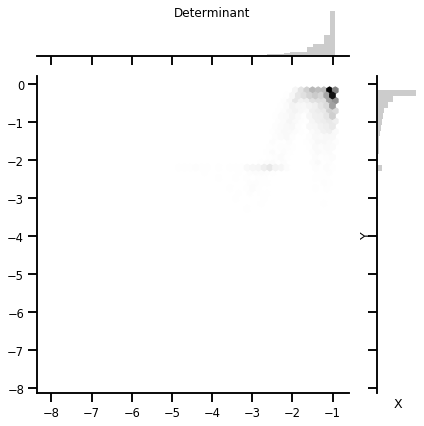

In [91]:
# estimated log probability of dataset
x_slogdet = marg_kde_clf.log_abs_det_jacobian(data)

print(x_slogdet.min(), x_slogdet.max())
plot_2d_joint(x_slogdet, title='Determinant', color='gray')

### Log Probability

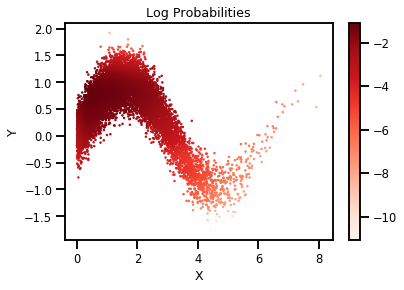

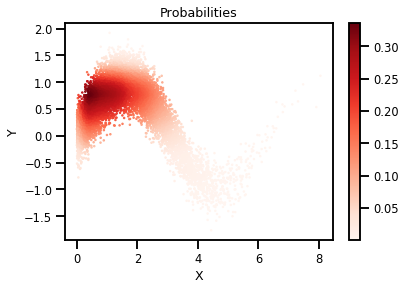

In [92]:
# calculate real log probability of distribution
x_prob = marg_kde_clf.score_samples(data)

plot_prob(data, x_prob, title='Log Probabilities')
plot_prob(data, np.exp(x_prob), title='Probabilities')

### Negative Log-Likelihood

In [93]:
x_score = marg_kde_clf.score(data)
print(x_score)

-2.188789555642612


In [86]:
x_score = marg_kde_clf.score(data)
print(x_score)

-2.1892535729804266


In [78]:
x_score = marg_kde_clf.score(data)
print(x_score)

-2.190176549687934


In [94]:
x_score = marg_hist_clf.score(data)
# data_score = data_dist.logpdf(X).mean()
print(x_score)

-2.0724144106060374
